In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/wns-inno/test_2umaH9m.csv
/kaggle/input/wns-inno/train_LZdllcl.csv
/kaggle/input/wns-inno/sample_submission_M0L0uXE.csv


In [6]:
import pandas as pd
import numpy as np
import pandas_profiling 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder ,OneHotEncoder 
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier 

import lightgbm as lgb

from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier,CatBoostRegressor


%matplotlib inline

In [7]:
path = '/kaggle/input/wns-inno/train_LZdllcl.csv'
path_t = '/kaggle/input/wns-inno/test_2umaH9m.csv'

df = pd.read_csv(path)
test = pd.read_csv(path_t)

df.head(2)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0


In [ ]:
df.dtypes

#### Null values

In [8]:
print(df.isnull().sum()[df.isnull().sum() > 0]/df.shape[0]*100)
print(test.isnull().sum()[test.isnull().sum() > 0]/df.shape[0]*100)


education               4.395344
previous_year_rating    7.524449
dtype: float64
education               1.886586
previous_year_rating    3.306087
dtype: float64


#### Distinct values

Text(0.5, 1.0, 'Unique_values')

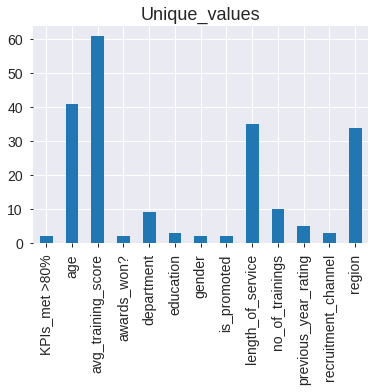

In [9]:
# Employee id is a unique identifier so we are not taking it!

df[df.columns.difference(['employee_id'])].apply(lambda x:x.nunique()).plot(kind = 'bar',fontsize = 14)
plt.title('Unique_values',fontsize = 18)

#### We have all unique employee Ids

In [10]:
df.employee_id.nunique()  == df.shape[0] # all unique

True

#### Handling Null values

- Dropping 6148 Null value rows

In [11]:
df.dropna(axis = 0,how = 'any',inplace = True)
test.dropna(axis = 0,how = 'any',inplace = True)

In [ ]:
df.shape

In [12]:
df._get_numeric_data().head(2)

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,1,35,5.0,8,1,0,49,0
1,65141,1,30,5.0,4,0,0,60,0


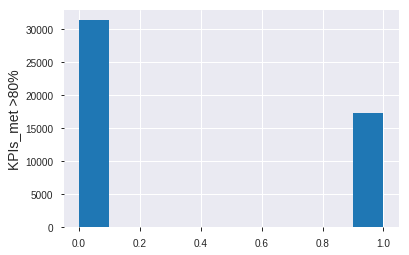

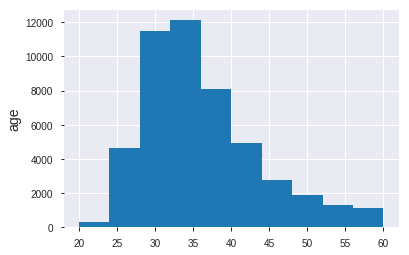

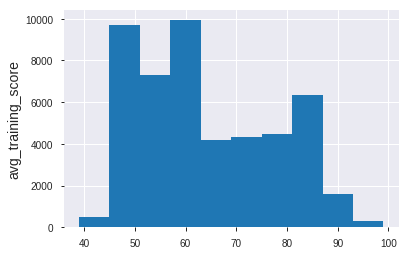

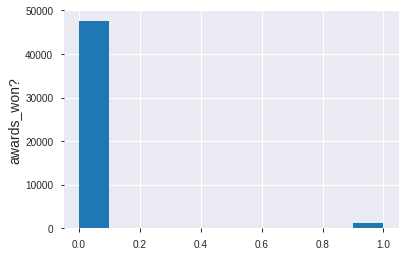

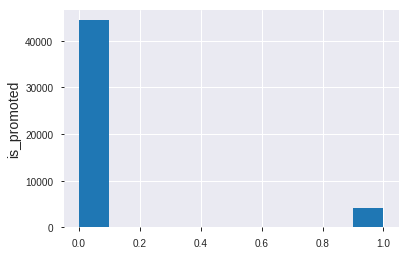

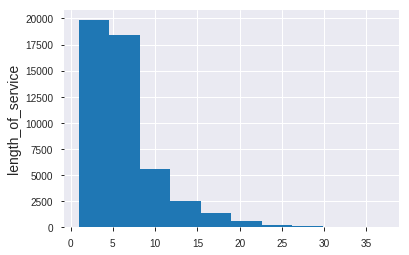

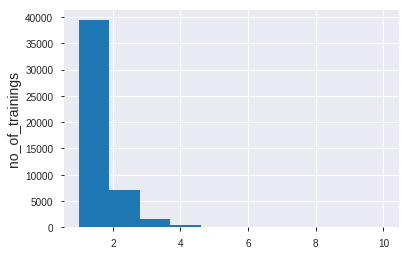

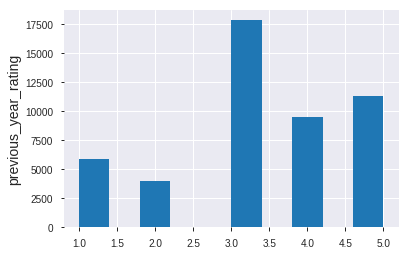

In [13]:
# Distribution of numeric columns 
for x in df._get_numeric_data().columns.difference(['employee_id']):
    plt.hist(df[x],bins = 10)
    plt.ylabel(x,fontsize = 14)
    plt.show()

In [ ]:
pandas_profiling.ProfileReport(df)

#### Handling the Nominal value

### SUMMARY

#### Number of observations 	54808
#### Missing cells 	6533 (0.9%)

#### Columns 
> Numeric 	6

> Categorical 	5

> Boolean 	3


> #### Nominal - To be fixed! 
  - Department : 9 variables : 2% - 30%
  - Education : 4 values : [70%,27%,1.5%]
  - Gender : Map binary : unbalanced || 1:2
  - is_promoted : Map binary
  - KPIs_met_>80% : Binary || 1:2
  - no_of_ratings : 10 values || might have to bin
  - recruitment_channel : 3 values 
  - region : 34 
  
  
* region - 34 (ordinal)
* recruitment_channel - 3 (dummy) ::: Done
* previous_year_rating - 5 ordinal( categories)
* no_of_trainings -  10 ordinal (4 major ratings)
* length_of_service - 35 ordinal 
* KPIs_met_>80% - binary
* is_promoted - binary 
* gender - binary
* education - 3 nominal (unbalanced) ::: Done
* df_index - 48660 (high cardinality)
* department - 9 categorical
* awards_won? - binary (unnbalanced)
* age - ordinal (41)
  

#### Handling recruitment channel

In [ ]:
?pd.get_dummies

In [14]:
df = pd.get_dummies(data = df,columns= ['recruitment_channel','education'],drop_first= True)
test = pd.get_dummies(data = test,columns= ['recruitment_channel','education'],drop_first= True)

# Handling Features

#### removing spaces from column names

In [15]:
df.columns = df.columns.str.replace(' ','_')

test.columns = test.columns.str.replace(' ','_')

df.columns

Index(['employee_id', 'department', 'region', 'gender', 'no_of_trainings',
       'age', 'previous_year_rating', 'length_of_service', 'KPIs_met_>80%',
       'awards_won?', 'avg_training_score', 'is_promoted',
       'recruitment_channel_referred', 'recruitment_channel_sourcing',
       'education_Below_Secondary', 'education_Master's_&_above'],
      dtype='object')

#### Mapping Gender

In [16]:
df.gender = df.gender.map({'f':1,'m':0})

test.gender = test.gender.map({'f':1,'m':0})

#### Department column fix

In [ ]:
df.department.value_counts()

In [ ]:
df.head(2)

In [17]:
le =  LabelEncoder()

df1 = df[['department','region']].apply(le.fit_transform)
df1.head(2)

test1 = test[['department','region']].apply(le.fit_transform)
test1.head(2)

,department,region
1,2,28
2,7,4


In [18]:
df2  = df[df.columns.difference(['department','region','employee_id'])]
df2.head(2)

test2  = test[test.columns.difference(['department','region','employee_id'])]
test2.head(2)

,KPIs_met_>80%,age,avg_training_score,awards_won?,education_Below_Secondary,education_Master's_&_above,gender,length_of_service,no_of_trainings,previous_year_rating,recruitment_channel_referred,recruitment_channel_sourcing
1,0,31,51,0,0,0,1,5,1,3.0,0,0
2,0,31,47,0,0,0,0,4,1,1.0,0,0


In [19]:
df_f = df1.merge(df2,left_index = True,right_index = True)

test_f = test1.merge(test2,left_index = True,right_index = True)

test_f.head(2)

,department,region,KPIs_met_>80%,age,avg_training_score,awards_won?,education_Below_Secondary,education_Master's_&_above,gender,length_of_service,no_of_trainings,previous_year_rating,recruitment_channel_referred,recruitment_channel_sourcing
1,2,28,0,31,51,0,0,0,1,5,1,3.0,0,0
2,7,4,0,31,47,0,0,0,0,4,1,1.0,0,0


In [20]:
X = df_f[df_f.columns.difference(['is_promoted'])]
Y = df_f.is_promoted

X = X.astype('int')

In [21]:
for x in X.columns:
    print(x,':::',X[x].unique(),'\n')

KPIs_met_>80% ::: [1 0] 

age ::: [35 30 34 39 45 31 33 28 32 49 37 38 27 29 26 57 40 42 23 59 44 50 56 20
 25 41 47 36 46 60 43 54 24 22 58 48 55 51 52 53 21] 

avg_training_score ::: [49 60 50 73 85 59 63 83 54 80 84 77 51 46 75 68 79 72 61 58 87 47 57 52
 88 71 48 65 62 53 78 44 91 82 69 74 86 90 92 67 89 56 76 81 70 45 55 39
 94 93 64 66 95 42 96 40 99 43 97 41 98] 

awards_won? ::: [0 1] 

department ::: [7 4 8 0 6 5 1 2 3] 

education_Below_Secondary ::: [0 1] 

education_Master's_&_above ::: [1 0] 

gender ::: [1 0] 

length_of_service ::: [ 8  4  7 10  2  5  6  3 16  9 26 12 11 17 14 13 19 15 23 20 18 22 25 28
  1 24 31 21 29 30 34 27 33 32 37] 

no_of_trainings ::: [ 1  2  3  4  7  5  6 10  8  9] 

previous_year_rating ::: [5 3 1 4 2] 

recruitment_channel_referred ::: [0 1] 

recruitment_channel_sourcing ::: [1 0] 

region ::: [31 14 10 15 18 11 12 27  0 28 21 24  6  5  2 29 20  8  4  7 17  1 19 23
  3 13 25 30 26 32 16 22 33  9] 



#### This is unbalanced class

In [ ]:
Y.value_counts()

#### Basic Model 

In [ ]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

In [ ]:
rc = RandomForestClassifier(oob_score= True)

In [22]:
params = {'max_depth' : [30] ,'n_estimators' : [90,100],'class_weight' : ["balanced"]}

# n_iter

In [ ]:
gscv = RandomizedSearchCV(rc, param_distributions= params ,cv = 5,n_jobs= -1,verbose = True,random_state=123,n_iter =10,scoring='f1')

In [ ]:
?RandomizedSearchCV

In [ ]:
gscv.fit(X,Y)

In [ ]:
gscv.best_estimator_

In [ ]:
gscv.best_params_

In [ ]:
print(gscv.scorer_)
print(gscv.best_score_)
print(gscv.best_estimator_.oob_score_)

#### LGBM

In [ ]:
# params1 = dict(max_depth= 8,learning_rate = .0941, num_leaves= 17, reg_alpha=3.4492 ,reg_lambda= 0.0422,n_estimators= [197,198]) 
# params1

In [ ]:
?lgb.LGBMClassifier

- Keeping Macx_dept the uncontrolled

In [23]:
lgbc1 = lgb.LGBMClassifier(max_depth = -1,subsample = 0.9,min_child_weight=0.0008,reg_alpha=2.8,reg_lambda=0.041,
                           colsample_bytree =0.75,min_child_samples = 17,scale_pos_weight = 3,subsample_for_bin=200000,
                           subsample_freq =1 ,num_leaves = 27,learning_rate = 0.07,
                           objective = 'binary',class_weight = None)
lgbm_cv1 = GridSearchCV(lgbc1,param_grid = dict(n_estimators= np.arange(100,110,1)),cv= 5,n_jobs= -1,verbose = True,scoring='f1')

In [24]:
lgbm_cv1.fit(X,Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.75,
        importance_type='split', learning_rate=0.07, max_depth=-1,
        min_child_samples=17, min_child_weight=0.0008, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=27, objective='binary',
        random_state=None, reg_alpha=2.8, reg_lambda=0.041,
        scale_pos_weight=3, silent=True, subsample=0.9,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=True)

In [25]:
print(lgbm_cv1.best_params_)
print(lgbm_cv1.best_score_)

{'n_estimators': 107}
0.530670274016971


#### Taking the optimized model and performing CV to check for early stopping 
#### Also validating if `n_iter` from early stopping is matching from gridsearchCV  

In [26]:
lgbm_cv1.best_estimator_.get_params()

dict_ = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.75,
 'importance_type': 'split',
 'learning_rate': 0.07,
 'max_depth': -1,
 'min_child_samples': 17,
 'min_child_weight': 0.0008,
 'min_split_gain': 0.0,
 'n_jobs': -1,
 'num_leaves': 27,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 2.8,
 'reg_lambda': 0.041,
 #'silent': True,
 'subsample': 0.9,
 'subsample_for_bin': 200000,
 'subsample_freq': 1,
 'scale_pos_weight': 3,
 'metric' : 'lgb_f1_score'
        }


In [ ]:
?lgb.cv
# cv_results

In [27]:
from sklearn.metrics import f1_score

# this is a UDF being put in f_eval
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

d_train = lgb.Dataset(X, label=Y)
cv_results = lgb.cv(params = dict_,train_set = d_train,num_boost_round = 150,nfold = 5,verbose_eval=10, early_stopping_rounds=30,feval=lgb_f1_score)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[10]	cv_agg's f1: 0.185593 + 0.00708392
[20]	cv_agg's f1: 0.343697 + 0.00864057
[30]	cv_agg's f1: 0.414892 + 0.00936608
[40]	cv_agg's f1: 0.497332 + 0.0112347
[50]	cv_agg's f1: 0.515905 + 0.011101
[60]	cv_agg's f1: 0.522746 + 0.011361
[70]	cv_agg's f1: 0.526084 + 0.0126227
[80]	cv_agg's f1: 0.527638 + 0.0133424
[90]	cv_agg's f1: 0.529987 + 0.0117775
[100]	cv_agg's f1: 0.529059 + 0.0103239
[110]	cv_agg's f1: 0.529756 + 0.0119159
[120]	cv_agg's f1: 0.527259 + 0.00961379


In [28]:
print('Current parameters:\n', dict_)
print('\nBest num_boost_round:', len(cv_results['f1-mean']))
print('Best CV score:', cv_results['f1-mean'][-1])

Current parameters:
 {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.75, 'importance_type': 'split', 'learning_rate': 0.07, 'max_depth': -1, 'min_child_samples': 17, 'min_child_weight': 0.0008, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 27, 'objective': 'binary', 'random_state': None, 'reg_alpha': 2.8, 'reg_lambda': 0.041, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 1, 'scale_pos_weight': 3, 'metric': 'lgb_f1_score'}

Best num_boost_round: 91
Best CV score: 0.5306069209433647


In [29]:
pred = lgbm_cv1.best_estimator_.predict(test_f)
pd.Series(pred).value_counts()

0    20717
1      102
dtype: int64

#### Bayesian optimizer

In [30]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

In [61]:
# include below until https://github.com/scikit-optimize/scikit-optimize/issues/718 is resolved
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')
        
# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = lgb.LGBMClassifier(
        objective='binary',
        metric='f1',
        n_jobs=-1,
        verbose=0
    ),
    search_spaces = {
        'learning_rate': (0.01,0.1, 'log-uniform'),
        'num_leaves': (10, 50),      
        'max_depth': (20, 200),
        'min_child_samples': (0, 50),
        'max_bin': (100, 1000),
        'subsample': (0.5, 1.0, 'log-uniform'),
        'subsample_freq': (0, 5),
        'colsample_bytree': (0.5, 1.0, 'log-uniform'),
        'min_child_weight': (0,1,'uniform'),
        'subsample_for_bin': (200000, 500000),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 5.0, 'log-uniform'),
        'scale_pos_weight': (1, 10, 'log-uniform'),
        'n_estimators': (100, 200)
    },    
    scoring = 'f1',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs = -1,
    n_iter = 20,   
    verbose = 0,
    refit = True,
    random_state = 42
)


def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")
    
    

# Fit the model
result = bayes_cv_tuner.fit(X.values, Y.values, callback=status_print)

Model #1
Best ROC-AUC: 0.5044
Best params: {'colsample_bytree': 0.6643907805165024, 'learning_rate': 0.0534226888747111, 'max_bin': 940, 'max_depth': 77, 'min_child_samples': 34, 'min_child_weight': 0.4141186324855385, 'n_estimators': 104, 'num_leaves': 40, 'reg_alpha': 8.973885442164155e-07, 'reg_lambda': 0.05936070635912049, 'scale_pos_weight': 3.5478393134703343, 'subsample': 0.545947382494233, 'subsample_for_bin': 253425, 'subsample_freq': 3}

Model #2
Best ROC-AUC: 0.5044
Best params: {'colsample_bytree': 0.6643907805165024, 'learning_rate': 0.0534226888747111, 'max_bin': 940, 'max_depth': 77, 'min_child_samples': 34, 'min_child_weight': 0.4141186324855385, 'n_estimators': 104, 'num_leaves': 40, 'reg_alpha': 8.973885442164155e-07, 'reg_lambda': 0.05936070635912049, 'scale_pos_weight': 3.5478393134703343, 'subsample': 0.545947382494233, 'subsample_for_bin': 253425, 'subsample_freq': 3}

Model #3
Best ROC-AUC: 0.5044
Best params: {'colsample_bytree': 0.6643907805165024, 'learning_ra

Model #20
Best ROC-AUC: 0.5188
Best params: {'colsample_bytree': 0.774779902991197, 'learning_rate': 0.06073400733783011, 'max_bin': 903, 'max_depth': 162, 'min_child_samples': 35, 'min_child_weight': 0.352787634650003, 'n_estimators': 104, 'num_leaves': 16, 'reg_alpha': 3.497797247521356e-09, 'reg_lambda': 0.5850812176396037, 'scale_pos_weight': 2.6740102917537096, 'subsample': 0.7330360741734041, 'subsample_for_bin': 382041, 'subsample_freq': 1}



In [62]:
pd.read_csv('LGBMClassifier_cv_results.csv').T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
split0_test_score,0.513576,0.500179,0.442125,0.476842,0.518258,0.505241,0.410239,0.519278,0.46403,0.463964,0.486562,0,0.418972,0.516833,0.203669,0.516917,0.299099,0.427866,0,0.484659
split1_test_score,0.493089,0.475755,0.433894,0.464917,0.513383,0.496802,0.411082,0.503428,0.451598,0.455465,0.482135,0,0.40159,0.498785,0.195184,0.511628,0.291892,0.426374,0,0.48444
split2_test_score,0.506557,0.513122,0.438794,0.503872,0.520071,0.511848,0.404754,0.515846,0.447933,0.451084,0.495656,0,0.430556,0.512943,0.204185,0.527933,0.297719,0.450324,0,0.497175
mean_test_score,0.504408,0.496352,0.438271,0.481876,0.517237,0.50463,0.408692,0.512851,0.454521,0.456838,0.488117,0,0.417039,0.50952,0.201012,0.518826,0.296237,0.434854,0,0.488758
std_test_score,0.00850089,0.0154927,0.00338037,0.0162967,0.00282419,0.00615753,0.00280563,0.00680849,0.00688917,0.005347,0.00562854,0,0.0119035,0.00775553,0.00412692,0.00679185,0.00312349,0.0109553,0,0.00595231
rank_test_score,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
mean_fit_time,0.95844,1.0278,0.890765,0.957335,0.945234,0.966523,0.975754,0.585915,0.785076,0.672186,0.589926,0.493906,0.548713,0.692139,0.773998,0.688726,1.12924,0.613739,0.510423,0.68379
std_fit_time,0.0838917,0.0617116,0.059948,0.0728712,0.0657103,0.0601523,0.0773792,0.045963,0.0610915,0.041402,0.0557907,0.0481831,0.0461981,0.0496237,0.0623941,0.0581216,0.0807863,0.0535978,0.022785,0.0618564
mean_score_time,0.164645,0.124545,0.160298,0.141288,0.150221,0.154446,0.143868,0.115979,0.144686,0.136192,0.101894,0.0877805,0.11785,0.114011,0.166651,0.124943,0.159065,0.0853446,0.106798,0.107595


In [49]:
stopper!

SyntaxError: invalid syntax (<ipython-input-49-0fb455405490>, line 1)

#### Tuning at granular level

In [ ]:
dic = dict(max_depth = -1,subsample = 0.9,min_child_weight=0.0008,reg_albpha=2.8,reg_lambda=0.041,
                           colsample_bytree =0.75,min_child_samples = 17,scale_pos_weight = 3,
                           subsample_freq =1 ,num_leaves = 27,learning_rate = 0.07,n_estimators = 101)

ser = pd.Series(dic).to_frame()
ser.rename(columns = {0:'value'},inplace = True)
ser[ser%1 == 0]

In [ ]:
dx = pd.DataFrame(np.where(ser.value%1 == 0,[ser.value-2,ser.value-1,ser.value,ser.value +1,ser.value +2],[ser.value*0.8,ser.value*0.9,ser.value,ser.value*1.1,ser.value*1.2])).T
dx

In [ ]:
arr = np.where(ser.value%1 == 0,[np.round(ser.value*0.8)-1,np.round(ser.value*0.9),np.round(ser.value),np.round(ser.value*1.1),np.round(ser.value*1.2)],[ser.value*0.8,ser.value*0.9,ser.value,ser.value*1.1,ser.value*1.2])


np.transpose(arr)[0]
# for x in np.transpose(arr):
#     da.append({'col':x},ignore_index=True)
# #     print(x)
    
# da

#### ---------------------------------------------------------------------------------

#### XGboost 

In [ ]:
# param_test1 = {
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2)
# }
import xgboost

gsearch1 = GridSearchCV(estimator = xgboost.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 
                        
 param_grid = {'max_depth':[10],'min_child_weight':[1]}, scoring='roc_auc',n_jobs=4,iid=False, cv=5)


gsearch1.fit( X, Y)

In [ ]:
 gsearch1.best_params_, gsearch1.best_score_

In [ ]:
gscv.scorer_

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

gridsearch_params